# 03-estimate-cheating-adoption-time.ipynb

In this section, we need the records of cheaters between March 1 and March 31.

1. Calculate the average kill ratio of cheaters.
* Calculate the average kill interval of cheaters.
* Estimate the start date of cheating for each cheater based on performance.
* Store the results in the S3 bucket.

## Load packages and read tables.

In [1]:
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read a table that contains edges.
spark.read.parquet("s3://social-research-cheating/data_for_estim.parquet").createOrReplaceTempView("td")

# Read a table that contains player data.
spark.read.parquet("s3://social-research-cheating/players.parquet").createOrReplaceTempView("players")

# Create a table of cheaters.
spark.sql("SELECT * FROM players WHERE cheating_flag == 1").createOrReplaceTempView("cheaters")

## 1. Calculate the average kill ratio by date.

In [4]:
# Create a dataframe that stores kills done by cheaters.
c_kill_logs = spark.sql("""SELECT mid, src, dst, time, m_date, ban_date 
                           FROM td t JOIN cheaters c ON t.src = c.id""")
c_kill_logs.registerTempTable("c_kill_logs")

# Calculate the number of kills of each cheater by date.
c_kills_by_date = spark.sql("""SELECT src AS id, m_date, COUNT(*) AS kills FROM c_kill_logs 
                               GROUP BY src, m_date""")
c_kills_by_date_df = c_kills_by_date.toPandas()

# Create a dataframe that stores death records of cheaters.
spark.sql("""SELECT mid, src, dst, time, m_date, ban_date 
             FROM td t JOIN cheaters c ON t.dst = c.id""").createOrReplaceTempView("c_death_logs")

# Calculate the number of deaths of each cheater by date.
c_deaths_by_date = spark.sql("""SELECT dst AS id, m_date, COUNT(*) AS deaths FROM c_death_logs 
                                GROUP BY dst, m_date""")
c_deaths_by_date_df = c_deaths_by_date.toPandas()

# Create a dataframe that contains both kills and deaths of each cheater by date.
dates_from_kills = c_kills_by_date_df[['id', 'm_date']]
dates_from_deaths = c_deaths_by_date_df[['id', 'm_date']]
temp = pd.concat([dates_from_kills, dates_from_deaths])
temp = temp.drop_duplicates(subset=['id', 'm_date'])

# Merge the two dataframes into one.
kill_info = pd.merge(temp, c_kills_by_date_df, how='outer', on=['id', 'm_date'])
kill_info = kill_info.fillna(0)
merged_df = pd.merge(kill_info, c_deaths_by_date_df, how='outer', on=['id', 'm_date'])
merged_df = merged_df.fillna(0)

# Calculate the kill ratio of each cheater by date.
merged_df['kill_ratio'] = merged_df['kills']/(merged_df['kills']+merged_df['deaths'])
avg_kill_ratio_by_date = merged_df[['id', 'm_date', 'kill_ratio']].sort_values(by=['id', 'm_date']).reset_index(drop=True)

# Show the top 20 rows.
print(avg_kill_ratio_by_date.head(20))

                                          id      m_date  kill_ratio
0   account.001dcc01a9b540df8835327cde8b7362  2019-03-16    0.558824
1   account.002dced5b2734143a4133cb58e0d0724  2019-03-01    0.906250
2   account.002dced5b2734143a4133cb58e0d0724  2019-03-02    0.866667
3   account.0040926df7204ffd93a41885a1175ced  2019-03-01    0.500000
4   account.0040926df7204ffd93a41885a1175ced  2019-03-02    0.428571
5   account.0040926df7204ffd93a41885a1175ced  2019-03-03    0.593750
6   account.0040926df7204ffd93a41885a1175ced  2019-03-04    0.333333
7   account.0040926df7204ffd93a41885a1175ced  2019-03-05    0.454545
8   account.0040926df7204ffd93a41885a1175ced  2019-03-07    0.770492
9   account.0040926df7204ffd93a41885a1175ced  2019-03-08    0.629630
10  account.0040926df7204ffd93a41885a1175ced  2019-03-09    0.416667
11  account.0040926df7204ffd93a41885a1175ced  2019-03-10    0.300000
12  account.00534c0bd3c342b6a63cd7b53c338d16  2019-03-06    0.956522
13  account.005c9165a57a46f09dfaf8

## 2. Calculate the average time difference between consecutive kills by date.

In [5]:
# Get a dataframe that stores kill records of cheaters.
kill_logs = c_kill_logs.toPandas()

# Calculate the time difference between kills for each match
kill_logs = kill_logs.sort_values(['src', 'mid', 'time'])
kill_logs['time'] = pd.to_datetime(kill_logs['time'])
kill_logs['delta'] = kill_logs.groupby(['mid', 'src'])['time'].diff()
kill_logs['delta'] = kill_logs['delta'] / np.timedelta64(1, 's')

# Calculate the average time difference between kills of cheaters by date.
time_diff_df = kill_logs[['src', 'm_date', 'delta']]
avg_kill_interval_by_date = time_diff_df.groupby(['src', 'm_date'], as_index=False).mean()

# Show the top 20 rows.
print(avg_kill_interval_by_date.head(20))

                                         src      m_date       delta
0   account.001dcc01a9b540df8835327cde8b7362  2019-03-16  367.854250
1   account.002dced5b2734143a4133cb58e0d0724  2019-03-01  127.790108
2   account.002dced5b2734143a4133cb58e0d0724  2019-03-02  196.118690
3   account.0040926df7204ffd93a41885a1175ced  2019-03-01  109.466667
4   account.0040926df7204ffd93a41885a1175ced  2019-03-02  183.393250
5   account.0040926df7204ffd93a41885a1175ced  2019-03-03  115.340400
6   account.0040926df7204ffd93a41885a1175ced  2019-03-04   21.478000
7   account.0040926df7204ffd93a41885a1175ced  2019-03-05  261.974000
8   account.0040926df7204ffd93a41885a1175ced  2019-03-07  199.051030
9   account.0040926df7204ffd93a41885a1175ced  2019-03-08  142.199800
10  account.0040926df7204ffd93a41885a1175ced  2019-03-09  264.764500
11  account.0040926df7204ffd93a41885a1175ced  2019-03-10         NaN
12  account.00534c0bd3c342b6a63cd7b53c338d16  2019-03-06  155.225667
13  account.005c9165a57a46f09dfaf8

## 3. Estimate the start date of cheating for each cheater based on performance.

In [6]:
# Create a dataframe that store the performance of cheaters.
avg_kill_interval_by_date.columns = ['id', 'm_date', 'delta']
combined_tab = pd.merge(avg_kill_ratio_by_date, avg_kill_interval_by_date, how='left', on=['id', 'm_date'])

combined_tab['kill_ratio'] = combined_tab['kill_ratio'].round(2)
combined_tab['delta'] = combined_tab['delta'].round(2)
combined_tab['flag'] = 0

# Change the value of flag into one if the record meets the following condition.
combined_tab.loc[(combined_tab['kill_ratio'] >= 0.8) & (combined_tab['delta'] <= 140), 'flag'] = 1
flagged_records =  combined_tab[combined_tab['flag'] == 1]
# print(flagged_records)

start_dates_df = flagged_records.groupby(['id']).first().reset_index()
start_dates = spark.createDataFrame(start_dates_df)
start_dates.registerTempTable("start_dates")
estimation = spark.sql("""SELECT c.id, s.m_date AS start_date, ban_date 
                          FROM cheaters c LEFT JOIN start_dates s ON c.id = s.id""")

# Calculate the period of cheating for each cheater.
estimation_df = estimation.toPandas()
estimation_df['ban_date'] = pd.to_datetime(estimation_df['ban_date'])
estimation_df['start_date'] = pd.to_datetime(estimation_df['start_date'])
estimation_df['period'] = (estimation_df['ban_date'] - estimation_df['start_date']).astype('timedelta64[D]') + 1
print(estimation_df.head(20))

                                          id start_date   ban_date  period
0   account.028c2a3e292843a69b70a745abc13d96 2019-03-04 2019-03-11     8.0
1   account.03589c43c62148488436cdddab22d354        NaT 2019-03-31     NaN
2   account.0d359dd89cb6460da3c5e9d0e2e9ffb5        NaT 2019-03-22     NaN
3   account.175b7548e97c4a50874f791462972dfa        NaT 2019-03-19     NaN
4   account.22c13cfd86f04a158bf5c5609ccbc906        NaT 2019-03-06     NaN
5   account.36c8019fc00646a9a8ead674e05620ba        NaT 2019-03-27     NaN
6   account.3935667f2c7443deb6ee47e8b9b09aab 2019-03-05 2019-03-06     2.0
7   account.57d64f7769474e5a923dab228a82a5d9        NaT 2019-03-31     NaN
8   account.5dc4344327774df5a6d27b1d2fae01fb        NaT 2019-03-21     NaN
9   account.6124b85515c44f16a55584523fd7e1e9        NaT 2019-03-14     NaN
10  account.74e33deb357d4c11a96a2892be2bfbff 2019-03-10 2019-03-11     2.0
11  account.871b87b5392d4b9da3c7ccf041b6d8cb        NaT 2019-03-09     NaN
12  account.8e688c4ed7054

In [10]:
# Remove cheaters without start date information.
complete_rows = estimation_df[estimation_df.period.notnull()]

# Resolve the settingwithcopywarning issue.
# https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
# http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

complete_rows['period'] = complete_rows['period'].astype('int') 
print(len(complete_rows))

2980


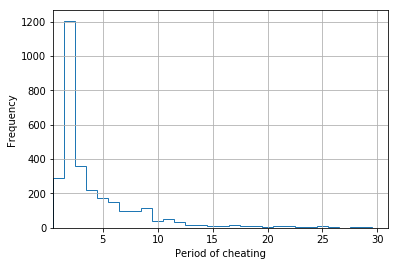

In [8]:
# Plot the distribution of the period of cheating.
# The plot contains cheaters who have full performance information.
bins = np.arange(0, complete_rows['period'].max() + 1.5) - 0.5
fig = complete_rows.hist(bins = bins, histtype='step')
plt.title('')
plt.xlim(xmin = 0.5)
plt.xlim(xmax = 31)
plt.xlabel('Period of cheating')
plt.ylabel('Frequency')
image = plt.show()

In [11]:
# Calculate the mean and median of period of cheating.
print(round(complete_rows['period'].mean(), 4))
print(complete_rows['period'].median())

# Count the number of cheaters who did cheat for two days.
print(len(complete_rows[complete_rows['period']==2]))

4.3648
2.0
1206


In [12]:
# Create a table that contains both start date and ban date of each cheater.
estimation_df = estimation.toPandas()
estimation_df['ban_date'] = pd.to_datetime(estimation_df['ban_date'])
estimation_df['start_date'] = pd.to_datetime(estimation_df['start_date'])
estimation_df['period'] = (estimation_df['ban_date'] - estimation_df['start_date']).astype('timedelta64[D]') + 1

# For cheaters with at least one missing performance information, we assume that they cheated for two days.
estimation_df['period'] = estimation_df['period'].fillna(2)
estimation_df['start_date'] = estimation_df['start_date'].fillna(estimation_df['ban_date'] - pd.to_timedelta(estimation_df['period']-1, unit='d'))
estimation_df['start_date'] = estimation_df['start_date'].astype('str')
estimation_df.loc[(estimation_df['start_date'] < '2019-03-01'), 'start_date'] = '2019-03-01'
estimation_df['start_date'] = pd.to_datetime(estimation_df['start_date'])
estimation_df['period'] = (estimation_df['ban_date'] - estimation_df['start_date']).astype('timedelta64[D]') + 1
print(estimation_df.head(20))

                                          id start_date   ban_date  period
0   account.028c2a3e292843a69b70a745abc13d96 2019-03-04 2019-03-11     8.0
1   account.03589c43c62148488436cdddab22d354 2019-03-30 2019-03-31     2.0
2   account.0d359dd89cb6460da3c5e9d0e2e9ffb5 2019-03-21 2019-03-22     2.0
3   account.175b7548e97c4a50874f791462972dfa 2019-03-18 2019-03-19     2.0
4   account.22c13cfd86f04a158bf5c5609ccbc906 2019-03-05 2019-03-06     2.0
5   account.36c8019fc00646a9a8ead674e05620ba 2019-03-26 2019-03-27     2.0
6   account.3935667f2c7443deb6ee47e8b9b09aab 2019-03-05 2019-03-06     2.0
7   account.57d64f7769474e5a923dab228a82a5d9 2019-03-30 2019-03-31     2.0
8   account.5dc4344327774df5a6d27b1d2fae01fb 2019-03-20 2019-03-21     2.0
9   account.6124b85515c44f16a55584523fd7e1e9 2019-03-13 2019-03-14     2.0
10  account.74e33deb357d4c11a96a2892be2bfbff 2019-03-10 2019-03-11     2.0
11  account.871b87b5392d4b9da3c7ccf041b6d8cb 2019-03-08 2019-03-09     2.0
12  account.8e688c4ed7054

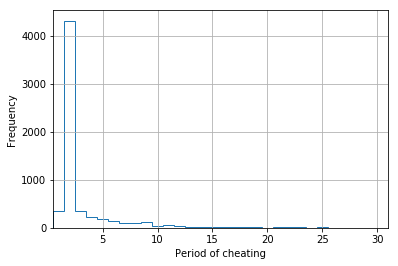

In [13]:
# Plot the distribution of the period of cheating.
# The plot contains all cheaters.
estimation_df['period'] = estimation_df['period'].astype('int')
bins = np.arange(0, estimation_df['period'].max() + 1.5) - 0.5
fig = estimation_df['period'].hist(bins=bins, histtype='step')
plt.title('')
plt.xlim(xmin = 0.5)
plt.xlim(xmax = 31)
plt.xlabel('Period of cheating')
plt.ylabel('Frequency')
image = plt.show()

## 4. Store the results in the S3 bucket.

In [14]:
estimation_df['start_date'] = estimation_df['start_date'].astype('str')
estimation_df['ban_date'] = estimation_df['ban_date'].astype('str')
cheater_info = spark.createDataFrame(estimation_df)
cheater_info.show(20)
cheater_info.write.parquet("s3://social-research-cheating/cheater-analysis/cheater_info.parquet")

+--------------------+----------+----------+------+
|                  id|start_date|  ban_date|period|
+--------------------+----------+----------+------+
|account.028c2a3e2...|2019-03-04|2019-03-11|     8|
|account.03589c43c...|2019-03-30|2019-03-31|     2|
|account.0d359dd89...|2019-03-21|2019-03-22|     2|
|account.175b7548e...|2019-03-18|2019-03-19|     2|
|account.22c13cfd8...|2019-03-05|2019-03-06|     2|
|account.36c8019fc...|2019-03-26|2019-03-27|     2|
|account.3935667f2...|2019-03-05|2019-03-06|     2|
|account.57d64f776...|2019-03-30|2019-03-31|     2|
|account.5dc434432...|2019-03-20|2019-03-21|     2|
|account.6124b8551...|2019-03-13|2019-03-14|     2|
|account.74e33deb3...|2019-03-10|2019-03-11|     2|
|account.871b87b53...|2019-03-08|2019-03-09|     2|
|account.8e688c4ed...|2019-03-10|2019-03-11|     2|
|account.b049cefce...|2019-03-19|2019-03-20|     2|
|account.b81481155...|2019-03-28|2019-03-29|     2|
|account.ba1f0c4b7...|2019-03-08|2019-03-09|     2|
|account.ba9

In [15]:
# Add the information of cheaters to the player data and store it to the S3 bucket for the later use.
cheater_info.registerTempTable("cheater_info")

nodes = spark.sql("""SELECT p.id, p.pname, p.cheating_flag, 
                     CASE WHEN c.start_date IS NULL THEN 'NA' ELSE c.start_date END AS start_date, 
                     CASE WHEN c.ban_date IS NULL THEN 'NA' ELSE c.ban_date END AS ban_date 
                     FROM players p LEFT JOIN cheater_info c ON p.id = c.id""")
print(nodes.count())
nodes.show(20)
nodes.write.parquet("s3://social-research-cheating/nodes.parquet")

1977329
+--------------------+--------------+-------------+----------+--------+
|                  id|         pname|cheating_flag|start_date|ban_date|
+--------------------+--------------+-------------+----------+--------+
|account.000171894...| Mirage_OwlEye|            0|        NA|      NA|
|account.001017dce...|   rlawltn1012|            0|        NA|      NA|
|account.0014b474d...|blue__lemonade|            0|        NA|      NA|
|account.0017aeb1b...|       k-will0|            0|        NA|      NA|
|account.001b6d0dc...|   kakaonodaab|            0|        NA|      NA|
|account.001c5d052...|      DGU_Ryan|            0|        NA|      NA|
|account.0026c9e0e...|       lkengn0|            0|        NA|      NA|
|account.00272763b...|   BTKnavyseal|            0|        NA|      NA|
|account.0028521c5...|      oyangang|            0|        NA|      NA|
|account.002ba9410...|       SUSAN_2|            0|        NA|      NA|
|account.003114883...|  wkddnwls2335|            0|     